<div align="center">
	<h1>CS 328: Introduction to Data Science</h1>
	<h2>Assignment 1</h2>
	Shardul Junagade <br>
	23110297
</div>

### Importing Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import rand_score
from sklearn.cluster import AgglomerativeClustering
from datasets import load_mnist


In [ ]:
class Cluster:
    def __init__(self, points):
        """Initialize a cluster with a list of points."""
        self.points = np.array(points)
        self.size = len(points)
        self.mean = self.compute_mean()
    
    def compute_mean(self):
        """Compute the mean of the cluster."""
        self.mean = np.mean(self.points, axis=0) if self.size > 0 else np.zeros(self.points.shape[1])
        return self.mean

## Question 1

Q1. Suppose you define a clustering objective in the following manner – given a partitioning $\mathbb{C} = \{C_1, \ldots, C_k\}$, define

$$
\text{cost}(\mathbb{C}) = \sum_{i=1}^{k} \frac{1}{|C_i|} \sum_{x, y \in C_i} \|x - y\|_2^2
$$

<div style="margin-left: 30px;">i.e., the cost of a cluster is the sum of all pairwise squared distances. Give an algorithm for this.</div>

### **Solution:**

To solve this problem, we need to design an algorithm that minimizes the given cost function for clustering. The cost function is defined as:

$$
\text{cost}(\mathbb{C}) = \sum_{i=1}^{k} \frac{1}{|C_i|} \sum_{x, y \in C_i} \|x - y\|_2^2
$$

This cost function penalizes clusters with large pairwise squared distances between points within the same cluster. Our goal is to minimize this cost by appropriately partitioning the data into $k$ clusters.


We can rewrite the cost function in terms of the mean of the clusters. Let $\mu_i$ be the mean of cluster $C_i$. The pairwise squared distance can be expressed as follows:

Expanding the paired distance:
$$
\|x - y\|_2^2 = \|x - \mu_i + \mu_i - y\|_2^2 = \|x - \mu_i\|_2^2 + \|\mu_i - y\|_2^2 + 2(x - \mu_i) \cdot (\mu_i - y)
$$

Expanding the sum over $x$ and $y$ in cluster $C_i$, we get:
$$
\sum_{x, y \in C_i} \|x - y\|_2^2 = \sum_{x, y \in C_i} \|x - \mu_i\|_2^2 + \sum_{x, y \in C_i} \|\mu_i - y\|_2^2 + 2 \sum_{x, y \in C_i} (x - \mu_i) \cdot (\mu_i - y)
$$

Since the dot product is symmetric, we have:
$$
\begin{align*}
\sum_{x, y \in C_i} (x - \mu_i) \cdot (\mu_i - y) &= \sum_{x, y \in C_i} (x \cdot \mu_i - x \cdot y - \mu_i \cdot \mu_i + \mu_i \cdot y) \\
&= |C_i|^2 \cdot \mu_i^2 - |C_i|^2 \cdot \mu_i^2 - |C_i|^2 \cdot \mu_i^2 + |C_i|^2 \cdot \mu_i^2 \\
&= 0
\end{align*}
$$

Since both sums are equal, we can write:
$$
\sum_{x, y \in C_i} \|x - y\|_2^2 = 2 \sum_{x, y \in C_i} \|x - \mu_i\|_2^2 = 2 \cdot |C_i| \sum_{x \in C_i} \|x - \mu_i\|_2^2
$$

Substituting this back into the cost function, we get:
$$
\text{cost}(\mathbb{C}) = \sum_{i=1}^{k} \frac{1}{|C_i|} \cdot 2 \cdot |C_i| \sum_{x \in C_i} \|x - \mu_i\|_2^2 
$$
$$
\text{cost}(\mathbb{C}) = 2 \sum_{i=1}^{k} \sum_{x \in C_i} \|x - \mu_i\|_2^2
$$

Thus, minimizing the original cost is equivalent to minimizing the sum of the squared distances between each point and the mean of its cluster. This is the same as the objective function of the k-means algorithm. Therefore, we can use the k-means algorithm to minimize the given cost function for clustering.

### Computing the Cost Function:

The cost function can be computed as follows:
1. Initialize the cost to zero.
2. For each cluster $C_i$:
	- Compute the mean $\mu_i$ of the cluster.
	- For each point $x$ in the cluster:
		- Compute the squared distance $\|x - \mu_i\|_2^2$.
		- Multiply this value by 2 and add it to the cost (for the given cost function).
3. Return the total cost.

### k-Means Clustering using Lloyd's Algorithm:

**Input:** Data points $x_1, x_2, \ldots, x_n$, number of clusters $k$.

1. **Initialization**: Randomly initialize $k$ cluster centers $\mu_1, \mu_2, \ldots, \mu_k$ from the data points.

2. **Assignment Step**: For each data point $x$, assign it to the cluster $C_i$ whose center $\mu_i$ minimizes the squared Euclidean distance:
     $$
     \|x - \mu_i\|_2^2
     $$

3. **Update Step**: For each cluster $C_i$, update the cluster center $\mu_i$ to be the mean of all points in $C_i$:
     $$
     \mu_i = \frac{1}{|C_i|} \sum_{x \in C_i} x
     $$

4. **Cost Calculation**:
   - After each iteration, compute the cost function:
     $$
     \text{cost}(\mathbb{C}) = \sum_{i=1}^{k} \sum_{x_j \in C_i} \left\| x_j - \mu_i \right\|^2
     $$
   - If the cost does not decrease significantly (below a threshold), stop the algorithm. Otherwise, repeat steps 2–4.

**Output:** The final clustering $\mathbb{C} = \{C_1, \ldots, C_k\}$.

This algorithm ensures that the given cost function (intra-cluster sum of squared distances) is minimized.

Here is a Python implementation of Lloyd's algorithm for k-means clustering:


In [40]:
class KMeansClustering:
    def __init__(self, X, k):
        self.X = X
        self.k = k
        self.centroids = None
        self.clusters = None
        self.labels = None

    def _initialize_centroids(self, init_method='random'):
        """Initialize the centroids of the clusters."""
        n, d = self.X.shape
        if init_method == 'random':
            self.centroids = self.X[np.random.choice(n, self.k, replace=False)]
        elif init_method == 'kmeans++':
            # Initialize centroids using kmeans++ method
            self.centroids = [self.X[np.random.choice(n)]]
            while len(self.centroids) < self.k:
                dist_sq = np.min(np.linalg.norm(self.X[:, np.newaxis] - np.array(self.centroids), axis=2)**2, axis=1)
                prob = dist_sq / np.sum(dist_sq)
                new_centroid = self.X[np.random.choice(n, p=prob)]
                self.centroids.append(new_centroid)
            self.centroids = np.array(self.centroids)
        else:
            raise ValueError("Invalid initialization method. Choose from 'random' or 'kmeans++'.")

    def fit(self, max_iters=100, tol=1e-4, init_method='random'):
        """Fit the KMeans model to the data."""
        # Initialize centroids using the chosen method
        self._initialize_centroids(init_method)
        for _ in range(max_iters):
            # Assign each point to the closest centroid
            distances = np.linalg.norm(self.X[:, np.newaxis] - self.centroids, axis=2)
            labels = np.argmin(distances, axis=1)
            # Compute new centroids
            new_centroids = np.array([self.X[labels == i].mean(axis=0) if np.any(labels == i) else self.centroids[i] for i in range(self.k)])
            # Check for convergence
            if np.linalg.norm(new_centroids - self.centroids) < tol:
                break
            self.centroids = new_centroids
        # Create clusters based on the final centroids
        self.clusters = [Cluster(self.X[labels == i]) for i in range(self.k)]
        self.labels = labels

    def get_centroids(self):
        return self.centroids

    def get_clusters(self):
        return self.clusters
    
    def get_labels(self):
	    return self.labels


### Complexity Analysis:
- **Time Complexity**:
  - The assignment step requires computing the squared Euclidean distance between each point and each cluster center, which takes $O(n \cdot k \cdot d)$ time, where $n$ is the number of data points, $k$ is the number of clusters, and $d$ is the dimensionality of the data.
  - The update step requires computing the mean of each cluster, which takes $O(n \cdot d)$ time.
  - The algorithm typically converges in a few iterations, with each iteration taking $O(n \cdot k \cdot d)$ time.
  - Overall, the time complexity is $O(t \cdot n \cdot k \cdot d)$, where $t$ is the number of iterations until convergence.

- **Space Complexity**:
    - The algorithm requires $O(n \cdot d)$ space to store the data points and cluster centers.
    - Additional space is needed for storing the cluster assignments and other variables, resulting in a space complexity of $O(n \cdot d)$.


### Example Usage:

Testing the algorithm on a sample dataset:

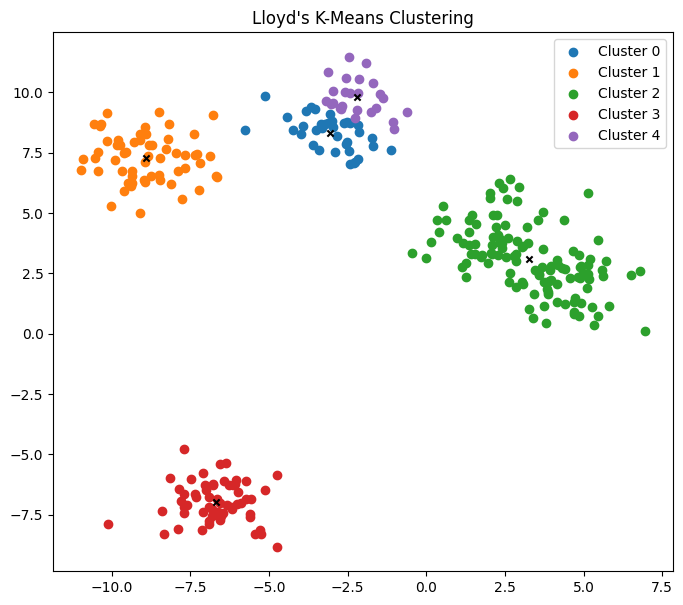

In [ ]:
# Generate synthetic dataset
n_samples = 300
n_features = 2
n_clusters = 5

X, y = make_blobs(n_samples=n_samples, centers=n_clusters, n_features=n_features, random_state=42)

# Apply Lloyd's K-Means Clustering
lloyd_kmeans = KMeansClustering(X, n_clusters)
lloyd_kmeans.fit()
lloyd_clusters = lloyd_kmeans.get_clusters()
lloyd_centroids = lloyd_kmeans.get_centroids()

plt.figure(figsize=(8, 7))
plt.title("Lloyd's K-Means Clustering")
for i, cluster in enumerate(lloyd_clusters):
	plt.scatter(cluster.points[:, 0], cluster.points[:, 1], label=f'Cluster {i}')
	plt.scatter(cluster.mean[0], cluster.mean[1], s=20, marker='x', color='black')
plt.legend()
plt.show()

## Question 2

Q2. For the $k$-means problem, show that there is at most a factor of four ratio between the optimal value when we either require all cluster centers to be data points or allow arbitrary points to be centers.


### Factor of Four Ratio in k-Means

Let $ X = \{x_1, x_2, \dots, x_n\} $ be a set of data points in $ \mathbb{R}^d $, and let $ C = \{c_1, c_2, \dots, c_k\} $ be a set of cluster centers. The k-means objective function is defined as:
$$
\Phi(X, C) = \sum_{x \in X} \min_{c \in C} \|x - c\|^2
$$

Let $ \text{OPT}_{\text{arbitrary}} $ be the optimal value of the k-means objective when centers are arbitrary points, and let $ \text{OPT}_{\text{data}} $ be the optimal value when centers are restricted to data points. We aim to show that:
$$
\text{OPT}_{\text{data}} \leq 4 \cdot \text{OPT}_{\text{arbitrary}}
$$

Let $ C_{\text{arbitrary}} = \{a_1, a_2, \dots, a_k\} $ be the optimal set of centers allowing arbitrary points, and let $ C_{\text{data}} = \{b_1, b_2, \dots, b_k\} $ be the optimal set of centers when constrained to data points. Then:
$$
\text{OPT}_{\text{arbitrary}} = \Phi(X, C_{\text{arbitrary}}) = \sum_{x \in X} \min_{a \in C_{\text{arbitrary}}} \|x - a\|^2
$$
$$
\text{OPT}_{\text{data}} = \Phi(X, C_{\text{data}}) = \sum_{x \in X} \min_{b \in C_{\text{data}}} \|x - b\|^2
$$

### Proof

Let $ C_{\text{arbitrary}} = \{a_1, a_2, \dots, a_k\} $ be the optimal set of centers (arbitrary points) that minimizes $ \Phi(X, C) $. For each optimal center $ a_i $, let $ b_i $ be the closest data point to $ a_i $, i.e.,
$$
b_i = \arg\min_{x \in X} \|x - a_i\|
$$

For any data point $ x \in X $, let $ a_i $ be its closest center in $ C_{\text{arbitrary}} $. By the triangle inequality,
$$
\|x - b_i\| \leq \|x - a_i\| + \|a_i - b_i\|
$$

Since $ b_i $ is the closest data point to $ a_i $, we have $ \|a_i - b_i\| \leq \|a_i - x\| $ for all $ x \in X $. Thus,
$$
\|x - b_i\| \leq 2 \|x - a_i\|
$$

Squaring both sides,
$$
\|x - b_i\|^2 \leq 4 \|x - a_i\|^2
$$

From the above inequality, we have:
$$
\min_{b \in C_{\text{data}}} \|x - b\|^2 \leq 4 \min_{a \in C_{\text{arbitrary}}} \|x - a\|^2
$$
$$
\begin{aligned}
&\text{where } C_{\text{data}} = \{b_1, b_2, \dots, b_k\} \text{ is the set of data points closest to the optimal centers in } C_{\text{arbitrary}}. \\
\end{aligned}
$$

Summing over all data points $ x \in X $,
$$
\sum_{x \in X} \min_{b \in C_{\text{data}}} \|x - b\|^2 \leq 4 \sum_{x \in X} \min_{a \in C_{\text{arbitrary}}} \|x - a\|^2
$$

$$
\text{OPT}_{\text{data}} \leq 4 \cdot \text{OPT}_{\text{arbitrary}}
$$

Therefore, we have proved that the optimal value of the k-means objective function when centers are restricted to data points is at most four times the optimal value when arbitrary points are allowed to be centers.  $\hspace{20pt}$ $\blacksquare$

## Question 3

Q3. Create a random variable $X$ for which Markov’s inequality is tight. Give proof for your answer. If it is tight, then why are we using other inequalities e.g. Chebyshev and Chernoff?

### **Solution:**

**Markov's Inequality** states that for any non-negative random variable $X$ and any $c > 0$, we have:
$$
P(X \geq c) \leq \frac{E[X]}{c}
$$

Let $X$ be a random variable that takes values $0$ and $a>0$. The probability mass function of $X$ is given by:
$$
P(X = x) = 
\begin{cases} 
1 - p & \text{if } x = 0 \\
p & \text{if } x = a
\end{cases}
$$

The expectation of $X$ is given by:
$$
E[X] = 0 \times (1 - p) + a \times p = ap
$$

Then by Markov's Inequality:
$$
P(X \geq c) \leq \frac{E[X]}{c} = \frac{ap}{c}
$$

If we choose $c = a$, then:
$$
P(X \geq a) \leq \frac{ap}{a} = p
$$

This is tight because the equality holds. The probability that $X$ is greater than or equal to $a$ is exactly $p$. This is the maximum probability that Markov's Inequality can give.


**Use of Other Inequalities (Chebyshev and Chernoff)**

- Markov's Inequality is tight only for specific distributions (e.g. the one we constructed above). For other distributions, Markov's Inequality may not be tight. It only uses the first moment of the random variable and does not take into account higher moments or the distribution shape.

- Chebyshev's Inequality is more general and provides a tighter bound than Markov's Inequality for any random variable with finite variance as it uses the second moment (variance) of the random variable. It is useful when we want a more precise estimate of the tail probabilities.
$$
P(|X - E[X]| \geq c) \leq \frac{Var[X]}{c^2}
$$


- Chernoff's Inequality is even tighter than Chebyshev's Inequality because it uses the moment generating function of the random variable. It provides exponentially decreasing bounds on tail probabilities. The inequalities are given by:

    - Upper Tail:
    $
    P(X \geq (1 + \delta)\mu) \leq e^{-\frac{\delta^2 \mu}{2 + \delta}}
    $
    for all $\delta > 0$;

    - Lower Tail:
    $
    P(X \leq (1 - \delta)\mu) \leq e^{-\frac{\delta^2 \mu}{2}}
    $
    for all $0 < \delta < 1$


## Question 4

Q4. Download the MNIST dataset from [http://yann.lecun.com/exdb/mnist/](http://yann.lecun.com/exdb/mnist/). We will use the test dataset and test labels only.

1. Cluster them first using k-means clustering, k = 10, with $kmeans++$ initialization (implement the complete Lloyd’s algorithm yourself). Check the Rand-index of the clustering against the true labels. Use the sklearn module for rand-index.
2. Do the same for $k$-center clustering, $k$ = 10. Implement the greedy algorithm discussed in class. Report the Rand-index here too.
3. Run the single linkage agglomeration till there are $k$ = 10 clusters. Report Rand-index here too.
4. Run the same algorithms (k-means and k-center) but on a rank-$k$ approximation of the training data matrix. Note that if $A$ is the training data matrix (images $×$ pixels), then you can just use $U_k Σ_k$ for the clustering, no need to use $V_k$. Evaluate for $k$ = 2,5,10 and report the rand-index values.


### **Solution:**

### Loading the MNIST Dataset

In [ ]:
X, y = load_mnist(path='./data/MNIST', kind='t10k', normalize=True)

print('X shape:', X.shape)
print('y shape:', y.shape)

In [ ]:
rand_scores = []

### k-Means Clustering

In [ ]:
kmeanspp = KMeansClustering(X, k=10)
kmeanspp.fit(init_method='kmeans++')

kmeanspp_rand = rand_score(y, kmeanspp.get_labels())
rand_scores.append(kmeanspp_rand)
print('K-Means++ Rand Index:', kmeanspp_rand)

K-Means++ Rand Index: 0.8908109410941094


### k-Center Clustering

In [ ]:
class KCenterClustering:
	def __init__(self, X, k):
		self.X = X
		self.k = k
		self.centers = None
		self.clusters = None
		self.labels = None

	def fit(self):
		n, d = self.X.shape
		# Initialize the centers
		self.centers = [self.X[np.random.choice(n)]]
		for _ in range(1, self.k):
			dist_sq = np.min(np.linalg.norm(self.X[:, np.newaxis] - np.array(self.centers), axis=2)**2, axis=1)
			new_center = self.X[np.argmax(dist_sq)]
			self.centers.append(new_center)
		self.centers = np.array(self.centers)
		# Assign each point to the closest center
		distances = np.linalg.norm(self.X[:, np.newaxis] - self.centers, axis=2)
		labels = np.argmin(distances, axis=1)
		# Create clusters based on the centers
		self.labels = labels
		self.clusters = [Cluster(self.X[labels == i]) for i in range(self.k)]

	def get_centers(self):
		return self.centers
	
	def get_clusters(self):
		return self.clusters
	
	def get_labels(self):
		return self.labels

In [ ]:
kcenter = KCenterClustering(X, k=10)
kcenter.fit()

kcenter_rand = rand_score(y, kcenter.get_labels())
rand_scores.append(kcenter_rand)
print('K-Center Rand Index:', kcenter_rand)

K-Center Rand Index: 0.6146236823682368


### Single Linkage Agglomeration

In [ ]:
single_linkage = AgglomerativeClustering(n_clusters=10, linkage='single')
single_linkage.fit(X)
single_linkage_rand = rand_score(y, single_linkage.labels_)
rand_scores.append(single_linkage_rand)
print('Single-Linkage Rand Index:', single_linkage_rand)

Single-Linkage Rand Index: 0.1017039703970397


### Rank-k Approximation

In [ ]:
def rank_k_approx(X, k):
	U, S, Vt = np.linalg.svd(X, full_matrices=False)
	return U[:, :k] @ np.diag(S[:k])

k_values = [2, 5, 10]

for k in k_values:
	X_rank_k = rank_k_approx(X, k)

	# K-Means on Rank-k approximated data
	kmeans_rank_k = KMeansClustering(X_rank_k, k=10)
	kmeans_rank_k.fit()
	kmeans_rank_k_rand = rand_score(y, kmeans_rank_k.get_labels())
	print(f'K-Means Rank-{k} Rand Index:', kmeans_rank_k_rand)

	# K-Center on Rank-k approximated data
	kcenter_rank_k = KCenterClustering(X_rank_k, k=10)
	kcenter_rank_k.fit()
	kcenter_rank_k_rand = rand_score(y, kcenter_rank_k.get_labels())
	print(f'K-Center Rank-{k} Rand Index:', kcenter_rank_k_rand)

	rand_scores.append([kmeans_rank_k_rand, kcenter_rank_k_rand])

K-Means Rank-2 Rand Index: 0.8306503850385039
K-Center Rank-2 Rand Index: 0.6551273927392739
K-Means Rank-5 Rand Index: 0.8706734673467347
K-Center Rank-5 Rand Index: 0.8010637863786378
K-Means Rank-10 Rand Index: 0.8773658365836584
K-Center Rank-10 Rand Index: 0.8150186618661867


### Final Results

In [ ]:
# print all rand scores question and bit wise
print('All Rand Scores:\n')
print(f"Q4. a) K-Means++ Rand Index     : {kmeanspp_rand:.4f}")
print(f"Q4. b) K-Center Rand Index      : {kcenter_rand:.4f}")
print(f"Q4. c) Single-Linkage Rand Index: {single_linkage_rand:.4f}")
print(f"Q4. d) Rank-2 : K-Means Rand Index: {rand_scores[3][0]:.4f}, K-Center Rand Index: {rand_scores[3][1]:.4f}")
print(f"       Rank-5 : K-Means Rand Index: {rand_scores[4][0]:.4f}, K-Center Rand Index: {rand_scores[4][1]:.4f}")
print(f"       Rank-10: K-Means Rand Index: {rand_scores[5][0]:.4f}, K-Center Rand Index: {rand_scores[5][1]:.4f}")


All Rand Scores:

Q4. a) K-Means++ Rand Index     : 0.8908
Q4. b) K-Center Rand Index      : 0.6146
Q4. c) Single-Linkage Rand Index: 0.1017
Q4. d) Rank-2 : K-Means Rand Index: 0.8307, K-Center Rand Index: 0.6551
       Rank-5 : K-Means Rand Index: 0.8707, K-Center Rand Index: 0.8011
       Rank-10: K-Means Rand Index: 0.8774, K-Center Rand Index: 0.8150
